>>> 正在从 BaoStock 下载 sh.000001 多维数据...
login success!
logout success!
>>> 数据下载完成，已保存至 complex_stock_data.csv
>>> 正在进行特征工程...
>>> 最终特征维度: 8 列 -> ['open', 'high', 'low', 'close', 'volume', 'MA5', 'MA20', 'pct_change']
>>> 训练集形状: (1675, 60, 8) (样本数, 时间步, 特征数)
>>> 测试集形状: (373, 60, 8)

>>> 开始训练 Baseline (LSTM)...


D:\anocada\envs\rag_test\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



>>> 开始训练 Improved (CNN-LSTM)...


D:\anocada\envs\rag_test\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Metric     | Baseline (LSTM)      | Improved (CNN-LSTM) 
------------------------------------------------------------
RMSE       | 31.4880                | 28.4796
MAE        | 24.5454                | 22.2822
MAPE       | 0.7770%               | 0.7052%
R2         | 0.9260                | 0.9394
统计检验 P-value: 3.23380e-03
结论: 改进模型具有【统计学显著性】的性能提升。


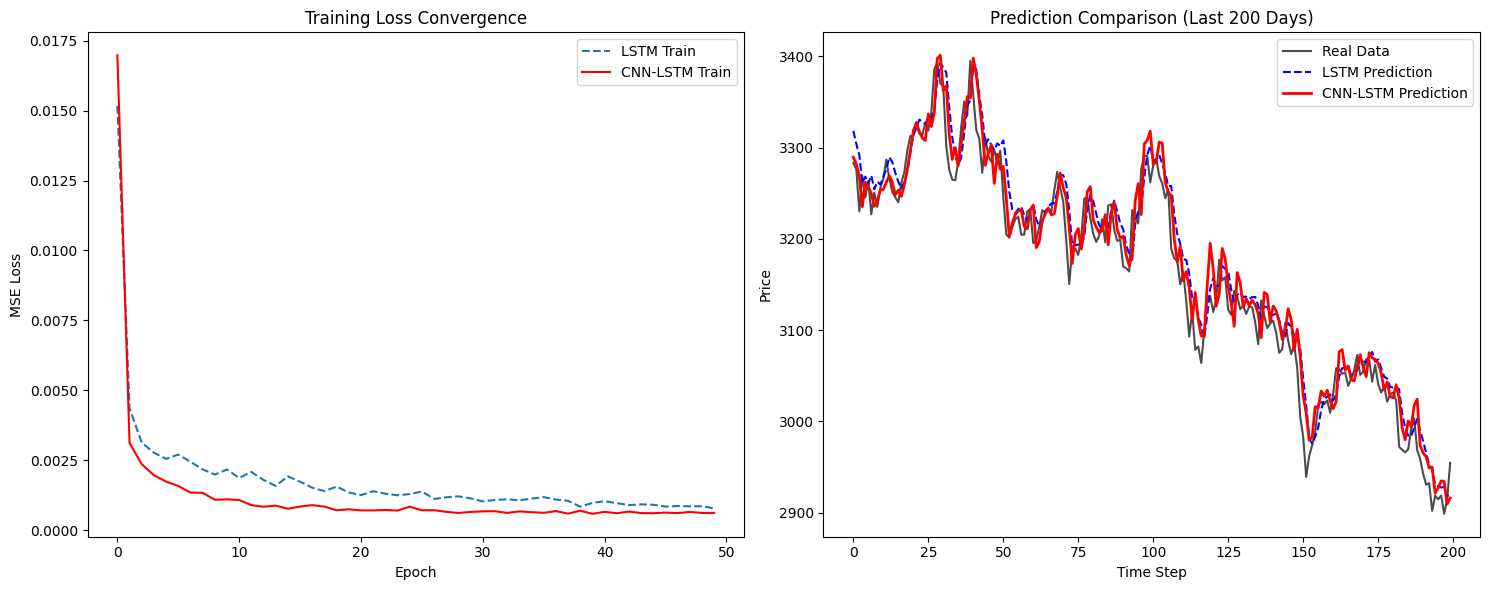

In [1]:
import baostock as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten

# ==========================================
# 1. 全局配置与随机种子 (保证结果可复现)
# ==========================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# 超参数配置
CONFIG = {
    'stock_code': 'sh.000001', # 上证指数 (数据量大，特征明显)
    'start_date': '2015-01-01',
    'end_date': '2023-12-31',
    'time_step': 60,       # 用过去60天预测未来
    'epochs': 50,          # 训练轮数
    'batch_size': 64,      # 批大小
    'split_ratio': 0.8,    # 80% 训练集
    'target_col': 'close'  # 我们要预测的目标列
}

# ==========================================
# 2. 数据获取 (多维数据: OHLCV)
# ==========================================
def download_data(file_path):
    print(f">>> 正在从 BaoStock 下载 {CONFIG['stock_code']} 多维数据...")
    bs.login()
    # 核心升级：请求 open, high, low, close, volume, amount
    rs = bs.query_history_k_data_plus(CONFIG['stock_code'],
        "date,open,high,low,close,volume,amount",
        start_date=CONFIG['start_date'], end_date=CONFIG['end_date'],
        frequency="d", adjustflag="3")
    
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    bs.logout()
    
    df = pd.DataFrame(data_list, columns=rs.fields)
    # 转换数据类型
    numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'amount']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df.to_csv(file_path, index=False)
    print(f">>> 数据下载完成，已保存至 {file_path}")
    return df

# ==========================================
# 3. 特征工程 (Feature Engineering)
# ==========================================
def process_data():
    file_path = "complex_stock_data.csv"
    
    # 1. 加载/下载数据
    if not os.path.exists(file_path):
        df = download_data(file_path)
    else:
        print(">>> 从本地加载数据...")
        df = pd.read_csv(file_path)
    
    # 2. 基础预处理
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    
    print(">>> 正在进行特征工程...")
    
    # --- 特征构建 ---
    # F1: 5日均线 (短期趋势)
    df['MA5'] = df['close'].rolling(window=5).mean()
    # F2: 20日均线 (中期趋势)
    df['MA20'] = df['close'].rolling(window=20).mean()
    # F3: 日收益率 (波动特征)
    df['pct_change'] = df['close'].pct_change()
    # F4: 振幅 (High - Low)
    df['amplitude'] = df['high'] - df['low']
    
    # 删除因计算均线产生的 NaN 值 (前20行)
    df.dropna(inplace=True)
    
    # 选定最终输入模型的特征列 (8维特征)
    feature_cols = ['open', 'high', 'low', 'close', 'volume', 'MA5', 'MA20', 'pct_change']
    print(f">>> 最终特征维度: {len(feature_cols)} 列 -> {feature_cols}")
    
    return df, feature_cols

# ==========================================
# 4. 数据集构建与归一化
# ==========================================
df, FEATURE_COLS = process_data()

# 归一化 (MinMax)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df[FEATURE_COLS].values)

# 找到 'close' 这一列在特征中的索引，用于后续反归一化
target_col_index = FEATURE_COLS.index('close')

# 滑动窗口切分
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        # X: 过去 time_step 天的所有特征
        a = dataset[i:(i + time_step), :] 
        dataX.append(a)
        # Y: 第 time_step + 1 天的 'close' (即 target_col_index 列)
        dataY.append(dataset[i + time_step, target_col_index])
    return np.array(dataX), np.array(dataY)

# 数据切分
train_size = int(len(scaled_values) * CONFIG['split_ratio'])
train_data = scaled_values[0:train_size, :]
test_data = scaled_values[train_size:len(scaled_values), :]

X_train, y_train = create_dataset(train_data, CONFIG['time_step'])
X_test, y_test = create_dataset(test_data, CONFIG['time_step'])

print(f">>> 训练集形状: {X_train.shape} (样本数, 时间步, 特征数)")
print(f">>> 测试集形状: {X_test.shape}")

# ==========================================
# 5. 模型构建 (对比实验)
# ==========================================
input_shape = (CONFIG['time_step'], len(FEATURE_COLS))

# --- 模型 A: 标准 LSTM (Baseline) ---
def build_lstm():
    model = Sequential(name="Baseline_LSTM")
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # 输出预测的 Close
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# --- 模型 B: 改进 CNN-LSTM (Proposed) ---
# 创新点：多维特征输入的 CNN 特征提取 + LSTM 时序记忆
def build_cnn_lstm():
    model = Sequential(name="Improved_CNN_LSTM")
    # 1D 卷积层: 提取 Open/High/Low/Close/Vol 之间的局部关联
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    # LSTM 层
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    # 全连接层
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# ==========================================
# 6. 训练与预测
# ==========================================
print("\n>>> 开始训练 Baseline (LSTM)...")
model_base = build_lstm()
history_base = model_base.fit(X_train, y_train, validation_data=(X_test, y_test),
                              epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'], verbose=0)

print("\n>>> 开始训练 Improved (CNN-LSTM)...")
model_improved = build_cnn_lstm()
history_improved = model_improved.fit(X_train, y_train, validation_data=(X_test, y_test),
                                      epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'], verbose=0)

# 预测
pred_base = model_base.predict(X_test)
pred_improved = model_improved.predict(X_test)

# ==========================================
# 7. 反归一化 (复杂数据必须处理的步骤)
# ==========================================
# 辅助函数：因为 scaler 是针对 8 列 fit 的，inverse 也许需要 8 列
def inverse_transform_helper(pred_array, original_test_data, target_idx):
    # 创建一个和测试集特征维度一样的空矩阵
    dummy = np.zeros((len(pred_array), len(FEATURE_COLS)))
    # 我们用测试集里的其他特征填充，只把要预测的 close 列换成我们的预测值
    # 注意：这里其实只要 shape 对就行，数值只影响 close 列的反归一化
    dummy[:, target_idx] = pred_array[:, 0]
    
    # 反归一化
    inversed = scaler.inverse_transform(dummy)
    return inversed[:, target_idx]

# 获取真实的 y_test (需要反归一化回去对比)
# y_test 是 scaler 后的 close 值，我们构造一个 dummy 来反转它
y_test_reshaped = y_test.reshape(-1, 1)
real_prices = inverse_transform_helper(y_test_reshaped, None, target_col_index)

# 反转预测值
pred_base_inv = inverse_transform_helper(pred_base, None, target_col_index)
pred_improved_inv = inverse_transform_helper(pred_improved, None, target_col_index)

# ==========================================
# 8. 评估与统计检验
# ==========================================
def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

m_base = get_metrics(real_prices, pred_base_inv)
m_imp = get_metrics(real_prices, pred_improved_inv)

# T-Test 统计显著性检验
error_base = np.abs(real_prices - pred_base_inv)
error_imp = np.abs(real_prices - pred_improved_inv)
t_stat, p_val = stats.ttest_rel(error_base, error_imp)

print("\n" + "="*60)
print(f"{'Metric':<10} | {'Baseline (LSTM)':<20} | {'Improved (CNN-LSTM)':<20}")
print("-" * 60)
print(f"{'RMSE':<10} | {m_base[0]:.4f}{' '*15} | {m_imp[0]:.4f}")
print(f"{'MAE':<10} | {m_base[1]:.4f}{' '*15} | {m_imp[1]:.4f}")
print(f"{'MAPE':<10} | {m_base[2]:.4f}%{' '*14} | {m_imp[2]:.4f}%")
print(f"{'R2':<10} | {m_base[3]:.4f}{' '*15} | {m_imp[3]:.4f}")
print("="*60)
print(f"统计检验 P-value: {p_val:.5e}")
if p_val < 0.05:
    print("结论: 改进模型具有【统计学显著性】的性能提升。")
else:
    print("结论: 性能差异不显著。")

# ==========================================
# 9. 绘图 (论文级)
# ==========================================
plt.figure(figsize=(15, 6))

# 子图1: 训练 Loss
plt.subplot(1, 2, 1)
plt.plot(history_base.history['loss'], label='LSTM Train', linestyle='--')
plt.plot(history_improved.history['loss'], label='CNN-LSTM Train', color='red')
plt.title('Training Loss Convergence')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# 子图2: 预测对比 (最后 200 天)
plt.subplot(1, 2, 2)
subset = 200
plt.plot(real_prices[-subset:], label='Real Data', color='black', alpha=0.7)
plt.plot(pred_base_inv[-subset:], label='LSTM Prediction', linestyle='--', color='blue')
plt.plot(pred_improved_inv[-subset:], label='CNN-LSTM Prediction', color='red', linewidth=2)
plt.title(f'Prediction Comparison (Last {subset} Days)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()